# Finetuning Text Summarization Notebook

## Hugging Face T5 transformer Trained on Custom Rotten Tomatoes 

# 


- Custom Rotten Tomatoes data is collecting hundreds of the top movies from IMDB, then
- Scraping those movies rotten tomatoes pages for:
    - **each critic consensus summary as y_target** 
    - **all critic reviews as combined x_train input**

In [1]:
from os.path import join, isfile
from os import listdir
import pandas as pd
import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import ModelCheckpoint
from rouge_score import rouge_scorer
import torch
from torch.utils.data import TensorDataset, random_split
from torch.utils.data import  DataLoader, RandomSampler, SequentialSampler #Dataset,
from transformers import get_linear_schedule_with_warmup, AdamW
from transformers import T5Tokenizer, T5ForConditionalGeneration

## Loading data from Hugging Face 

In [2]:
df = pd.read_pickle('../ingestion/rotten_tomatoes_training_df.pkl')
print(df.shape)
df.head()

(2152, 6)


,movie_key,reviews,url,critic_summary,user_summary,movie
0,a_quiet_place_part_ii,"[Really tense throughout the movie, the sequen...",https://www.rottentomatoes.com/m/a_quiet_place...,A nerve-wracking continuation of its predecess...,"Almost as scary and intense as the original, A...",A Quiet Place Part II
1,being_the_ricardos,[Nicole Kidman transforms herself into Lucile ...,https://www.rottentomatoes.com/m/being_the_ric...,Being the Ricardos can't hope to truly capture...,It'll probably mean most to viewers who grew u...,Being the Ricardos
2,belle_2022,"[Very beautiful movie, masterpiece 🎆🌌🌠🎇 but de...",https://www.rottentomatoes.com/m/belle_2022,A remarkable story brought to life with dazzli...,"Beautiful to watch as well as listen to, Belle...",Belle
3,bo_burnham_inside,[This special is not for me but it is definetl...,https://www.rottentomatoes.com/m/bo_burnham_in...,A claustrophobic masterclass in comedy and int...,A brilliant blend of sharp humor and emotional...,Inside
4,candyman_2021,[There are some really interesting ideas in th...,https://www.rottentomatoes.com/m/candyman_2021,"Candyman takes an incisive, visually thrilling...",The 2021 Candyman may not be as scary as the o...,Candyman


In [3]:
def truncate_reviews(text = list) -> str:
    '''
    take a list of reviews and return only n amount depending on desired char len
    '''
    text = text[:250]
    text = ' '.join([str(t) for t in text])
    return text

In [4]:
df['text'] = df['reviews'].apply(lambda x: truncate_reviews(x))

In [5]:
df = df[['critic_summary', 'text']]
df.columns = ['ctext', 'text']
print(df.shape)
df.head()

(2152, 2)


,ctext,text
0,A nerve-wracking continuation of its predecess...,"Really tense throughout the movie, the sequenc..."
1,Being the Ricardos can't hope to truly capture...,Nicole Kidman transforms herself into Lucile B...
2,A remarkable story brought to life with dazzli...,"Very beautiful movie, masterpiece 🎆🌌🌠🎇 but def..."
3,A claustrophobic masterclass in comedy and int...,This special is not for me but it is definetly...
4,"Candyman takes an incisive, visually thrilling...",There are some really interesting ideas in thi...


In [6]:
df['ctext'].values[234]

"Driven by Al Pacino and Robin Williams' performances, Insomnia is a smart and riveting psychological drama."

In [118]:
df['text'].values[234][:500]

"Watching Nolan's final pre-Batman outing reveals a subtle finessing of his M.O. - not just thematically, but visually. Dormer has a weariness that Pacino wears perfectly, always finding some new depth to his exhaustion and despair without ever being a sleepy presence on screen. A deceptively run-of-the-mill cop thriller based round an ingenious psychological theme. ...evocative imagery, a compelling story, and one of Pacino's best performances of the 21st century. Insomnia is not so much about t"

## Model building 

In [8]:
class T5Finetuner(pl.LightningModule):
    '''
    Documentation-In-Progress
    '''

    def __init__(self, df = pd.DataFrame , bs = int):
        super().__init__()
        self.save_hyperparameters()
        self.source_len = 512
        self.summ_len = 200
        self.lr = .0001
        self.bs = 8
        self.num_workers = 8
        self.model = T5ForConditionalGeneration.from_pretrained(MODEL_NAME)
        self.tokenizer = T5Tokenizer.from_pretrained(MODEL_NAME)
        self.data = df
        self.scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
        self.output = 'temp/'
        self.name = 'test'

    def encode_text(self, context, text):
        ctext = str(context) # context text 
        ctext = ' '.join(ctext.split())
        text = str(text) # summarized text
        text = ' '.join(text.split())
        source = self.tokenizer.batch_encode_plus([ctext], 
                                                max_length= self.source_len, 
                                                truncation=True,
                                                padding='max_length',
                                                return_tensors='pt')
        target = self.tokenizer.batch_encode_plus([text], 
                                                max_length= self.summ_len,
                                                truncation=True,
                                                padding='max_length',
                                                return_tensors='pt')
        y = target['input_ids']
        target_id = y[:, :-1].contiguous()
        target_label = y[:, 1:].clone().detach()
        target_label[y[:, 1:] == self.tokenizer.pad_token_id] = -100 #edge-case  handling when no labels are there
        return source['input_ids'], source['attention_mask'], target_id, target_label
    
    def prepare_data(self):
        source_ids, source_masks, target_ids, target_labels = [], [], [], [] 
        for _, row in self.data.iterrows():
            source_id, source_mask, target_id, target_label = self.encode_text(row.ctext, row.text)
            source_ids.append(source_id)
            source_masks.append(source_mask)
            target_ids.append(target_id)
            target_labels.append(target_label)

        # Transforming lists into tensors
        source_ids = torch.cat(source_ids, dim=0)
        source_masks = torch.cat(source_masks, dim=0)
        target_ids = torch.cat(target_ids, dim=0)
        target_labels = torch.cat(target_labels, dim=0)
        # Splitting data into standard train, val, and test sets 
        data = TensorDataset(source_ids, source_masks, target_ids, target_labels)
        train_size, val_size = int(0.8 * len(data)), int(0.1 * len(data))
        test_size = len(data) - (train_size + val_size)
        self.train_dat, self.val_dat, self.test_dat = \
            random_split(data, [train_size, val_size, test_size])
    
    def forward(self, batch, batch_idx):
        source_ids, source_mask, target_ids, target_labels = batch[:4]
        return self.model(
            input_ids = source_ids, 
            attention_mask = source_mask, 
            decoder_input_ids=target_ids, 
            labels=target_labels
        )
        
    def training_step(self, batch, batch_idx):
        loss = self(batch, batch_idx)[0]
        self.log('train loss', loss, prog_bar = True, logger = True)
        return {'loss': loss, 'log': {'train_loss': loss}}

    def validation_step(self, batch, batch_idx):
        loss = self(batch, batch_idx)[0]
        self.log('valid loss', loss, prog_bar = True, logger = True)
        return {'loss': loss}

    def validation_epoch_end(self, outputs): 
        loss = sum([o['loss'] for o in outputs]) / len(outputs)
        out = {'val_loss': loss}
        return {**out, 'log': out}

    def test_step(self, batch, batch_idx):
        loss = self(batch, batch_idx)[0]
        self.log('test loss', loss, prog_bar = True, logger = True)
        return {'loss': loss}

    def test_epoch_end(self, outputs):
        loss = sum([o['loss'] for o in outputs]) / len(outputs)
        out = {'test_loss': loss}
        return {**out, 'log': out}
    
    def train_dataloader(self):
        return DataLoader(
            self.train_dat,
            batch_size=self.bs,
            num_workers=self.num_workers, 
            sampler=RandomSampler(self.train_dat)
        )

    def val_dataloader(self):
        return DataLoader(
            self.val_dat, 
            batch_size=self.bs, 
            num_workers=self.num_workers,
            sampler=SequentialSampler(self.val_dat)
        )

    def test_dataloader(self):
        return DataLoader(
            self.test_dat, 
            batch_size=self.bs, 
            num_workers=self.num_workers,
            sampler=SequentialSampler(self.test_dat)
        )    

    def configure_optimizers(self):
        optimizer = AdamW(self.model.parameters(), lr=self.lr, eps=1e-4)
        return {'optimizer': optimizer}
    
    def save_core_model(self):
        store_path = join(self.output, self.name, 'core')
        self.model.save_pretrained(store_path)
        self.tokenizer.save_pretrained(store_path)

In [9]:
class MetricsCallback(pl.Callback):
    def __init__(self):
        super().__init__()
        self.metrics = []

    def on_validation_end(self, trainer, pl_module):
        self.metrics.append(trainer.callback_metrics)

## Selecting model name 

In [10]:
#######################
MODEL_NAME = 't5-base'
#######################
num_epochs = 10 # some training, but not too much to prevent overfitting
batch_size = 50 # decent batch size to help with convergence but not too much to also prevent overfitting
tokenizer = T5Tokenizer.from_pretrained(MODEL_NAME)
model = T5Finetuner(df = df, bs = batch_size)

## freezing all but the last N layers 

In [11]:
def unfreeze_last_n_layers(model = None, num_layers = int):
    '''
    Freezes all layers, except the last n layers specified by num_layers
    '''
    len_parameters = len(list(model.parameters()))
    num_layers_frozen = num_layers
    idx = 0
    for param in model.parameters():
        idx += 1
        if idx < len_parameters+1-num_layers_frozen:
    #         print(idx)
            param.requires_grad = False
        else:
            layer_number = len_parameters+1-num_layers_frozen
            print(f'-{len_parameters-(idx-1)} layer is unfrozen')

In [12]:
unfreeze_last_n_layers(model = model, num_layers = 1)

-1 layer is unfrozen


## Loading tensorboard for logging 

In [13]:
%load_ext tensorboard
%tensorboard --logdir ./lightning_logs --host localhost --port 7000

Reusing TensorBoard on port 7000 (pid 38232), started 5 days, 17:09:19 ago. (Use '!kill 38232' to kill it.)

In [14]:
experiment_name = 'fine_tuning_text_summarizer_rt_v_0_3'

checkpoint_callback = ModelCheckpoint(
    dirpath = 'checkpoints', 
    filename = 'best-checkpoint', 
    save_top_k = 1, 
    verbose = True, 
    monitor = 'val_loss', 
    mode= 'min', 
)

logger = TensorBoardLogger('lightning_logs', name  = experiment_name) 

trainer = pl.Trainer(
    logger = logger, 
    checkpoint_callback = checkpoint_callback, 
    max_epochs = num_epochs, 
    gpus = 1)

C:\Users\megra\anaconda3\envs\textsum_env\lib\site-packages\pytorch_lightning\trainer\connectors\callback_connector.py:147: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=<pytorch_lightning.callbacks.model_checkpoint.ModelCheckpoint object at 0x000001EE721BE970>)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=<pytorch_lightning.callbacks.model_checkpoint.ModelCheckpoint object at 0x000001EE721BE970>)`.
  rank_zero_deprecation(
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


## Adjust learning rate using lr_finder

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\megra\anaconda3\envs\textsum_env\lib\site-packages\pytorch_lightning\trainer\data_loading.py:116: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
C:\Users\megra\anaconda3\envs\textsum_env\lib\site-packages\pytorch_lightning\trainer\data_loading.py:116: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

C:\Users\megra\anaconda3\envs\textsum_env\lib\site-packages\pytorch_lightning\loops\optimization\closure.py:35: LightningDeprecationWarning: One of the returned values {'log'} has a `grad_fn`. We will detach it automatically but this behaviour will change in v1.6. Please detach it manually: `return {'loss': ..., 'something': something.detach()}`
  rank_zero_deprecation(
Restoring states from the checkpoint path at C:\Users\megra\Desktop\repos\text_summarization\training\lr_find_temp_model_04316d1c-a333-4fec-b189-2407470b4885.ckpt
C:\Users\megra\AppData\Local\Temp/ipykernel_15732/2787918662.py:10: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


suggested learning rate is: 0.030199517204020192


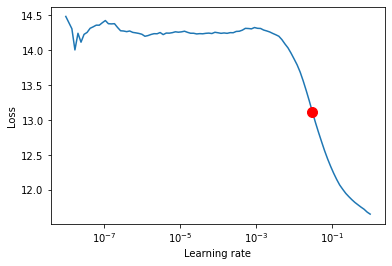

In [15]:
#reducing model.num_workers because it sometimes errors out using tuner.lr_finder
old_num_workers = model.num_workers
model.num_workers = 1

# Run learning rate finder
lr_finder = trainer.tuner.lr_find(model)

# Plot suggested lr
fig = lr_finder.plot(suggest=True)
fig.show()

#use suggested learning rate 
print(f'suggested learning rate is: { lr_finder.suggestion()}')
model.hparams.lr =  lr_finder.suggestion()

#reverting model.num_workers back to initial num
model.num_workers = old_num_workers

In [16]:
trainer.fit(model)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type                       | Params
-----------------------------------------------------
0 | model | T5ForConditionalGeneration | 222 M 
-----------------------------------------------------
768       Trainable params
222 M     Non-trainable params
222 M     Total params
891.614   Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

C:\Users\megra\anaconda3\envs\textsum_env\lib\site-packages\pytorch_lightning\loops\optimization\closure.py:35: LightningDeprecationWarning: One of the returned values {'log'} has a `grad_fn`. We will detach it automatically but this behaviour will change in v1.6. Please detach it manually: `return {'loss': ..., 'something': something.detach()}`
  rank_zero_deprecation(


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

## Loading best model in training 

In [17]:
trained_model = T5Finetuner.load_from_checkpoint(trainer.checkpoint_callback.best_model_path)

In [19]:
import joblib
experiment_name = 'fine_tuning_text_summarizer_rt_v_0_2'
model_path = trainer.checkpoint_callback.best_model_path
joblib.dump(model_path, f'model_path_{experiment_name}.txt')
model_path

'lightning_logs\\fine_tuning_text_summarizer_rt_v_0_3\\version_8\\checkpoints\\epoch=9-step=2159.ckpt'

In [20]:
trained_model.freeze()

## Inference 

In [116]:
from nltk import word_tokenize

class Inference():
    def get_example(index = int):
        full_text = df['text'].values[index]
        summary = df['ctext'].values[index]
        return full_text, summary
    
    def clean_prediction(text = str) -> str: 
        sentences =text.split('. ')
        suspect_words = word_tokenize(sentences[-1])
        if '.' in suspect_words:
            clean_text= '. '.join(sentences)
        else: 
            clean_text= '. '.join(sentences[:-1])
        return clean_text

    def summarize(trained_model, tokenizer, text): 
        text_encoding = tokenizer(
            text,
            max_length = 512, 
            padding = 'max_length', 
            truncation = True, 
            return_attention_mask = True, 
            return_tensors = 'pt'
        )
    #     generated_ids = trained_model.model.generate(
        generated_ids = trained_model.model.generate(
            input_ids=text_encoding['input_ids'], 
            attention_mask = text_encoding['attention_mask'], 
            max_length = 50,# max length of summary
            num_beams = 10,# more means mean more probable next words to consider 
            repetition_penalty = 5.0,# higher number means more unique words used
            length_penalty = 1.0,
            no_repeat_ngram_size=2, 
            early_stopping = True
        )
        preds = [
            tokenizer.decode(gen_id, 
                skip_special_tokens = True, 
                clean_up_tokenization_spaces = True)
            for gen_id in generated_ids
        ]
        return "".join(preds)
        
example_index = 234

example_text, example_summary = Inference.get_example(example_index)
print('~~~ Original summary: \n\n', example_summary)

~~~ Original summary: 

 Driven by Al Pacino and Robin Williams' performances, Insomnia is a smart and riveting psychological drama.


In [113]:
# generating prediction from T5Finetuner method summarize 
prediction = Inference.summarize(trained_model, tokenizer, example_summary)
Inference.clean_prediction(prediction)

"Henri Dormer is one of Pacino's best performances, almost vanity free....a deceptively run-of-the-earth cop thriller based round an ingenious psychological theme"

In [114]:
#using RougeScorer to assess example 
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
scorer.score(example_summary, prediction)

{'rouge1': Score(precision=0.9259259259259259, recall=0.007179781734635267, fmeasure=0.014249073810202337),
 'rouge2': Score(precision=0.8461538461538461, recall=0.006320022981901752, fmeasure=0.012546335899629312),
 'rougeL': Score(precision=0.7037037037037037, recall=0.005456634118322803, fmeasure=0.010829296095753777)}